In [4]:
# ======================================================================================
# Notebook setup
# 
# Run this cell before all others to make sure that the Jupyter notebook works properly
# ======================================================================================

# Automatically reload all imported modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

figsize = (14, 3.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Decision Trees

## Decision Trees

**_Decision Trees_ are a type of Machine Learning model**

* They were originally introduced for classification tasks
* ...And they provide a prediction via _recursive splitting_

<center>
<img src="assets/DT.png" width=50%/>
</center>

## Decision Trees

**_Decision Trees_ are a type of Machine Learning model**

* Decision Trees consist of nodes, connected by parent-child relations
* There is a single _root_ with no parent. Nodes with no child are called _leaves_

<center>
<img src="assets/DT.png" width=50%/>
</center>

## Decision Trees

**_Decision Trees_ are a type of Machine Learning model**

* The decision process always starts from the root
* ...And leaf nodes are labeled with a prediction

<center>
<img src="assets/DT.png" width=50%/>
</center>

## Decision Trees

**_Decision Trees_ are a type of Machine Learning model**

* Non-leaves node correspond to a fork in the decision process
* ...When making predictions, a child is picked _based on the value of one attribute_

<center>
<img src="assets/DT.png" width=50%/>
</center>

## Decision Trees

**Decision Trees are a type of _symbolic_ ML models**

...Actually, they are among the best examples of a symbolic technique

* They are _interpretable_
* They reason using discrete concepts
* They are easy to analyze

**They are very versatile**

* They can handle both categorical and numerical input
* They can handle inputs with _missing values_
* They can approximate non-linear relation

**They serve as the basis for _some of the most effective ML methods_**

...Such as Random Forests, Gradient Boosted Trees, and Extra Randomized Trees

## Learning a Decision Trees

**Decision trees are constructed via a recursive algorithm**

* $\text{learn}(x, y, n):$
  - $\text{if a stopping condition is met:}:$
    - $\text{return a leaf labeled with the majority class}$
  - $\text{if the termination condition is not satisfied}:$
      - $\text{pick an optimal attribute $j$ and threshold $\theta$}$
      - $\text{$n_{\mathit{left}} = $ learn$(x_{x_j \leq \theta}, y_{x_j \leq \theta})$}$
      - $\text{$n_{\mathit{right}} = $ learn$(x_{x_j > \theta}, y_{x_j > \theta})$}$
      - $\text{connect $n_{\mathit{left}}$ and $n_{\mathit{right}}$ to the rest of the tree}$

The process starts by calling $\text{learn}$ with the original training set and $n = \text{root}$

## Learning Decision Trees

**How do we evaluate an attribute and threshold?**

Typically, we look at the _uniformity of the resulting split_

* We say that a $j$, $\theta$ is better
* ...If it leads to more uniform training sets in the children nodes

**In detail:**

* We consider the two vectors $y_{x_j \leq \theta}$ and $y_{x_j > \theta}$
* For each of them we compute a _impurity index_ $H(y_{x_j \leq \theta})$ and $H(y_{x_j < \theta})$
* Then we average over the set size:

$$
\frac{|y_{x_j \leq \theta}|}{|y|} H(y_{x_j \leq \theta}) +
\frac{|y_{x_j > \theta}|}{|y|} H(y_{x_j > \theta})
$$

In practice, there are a few important adjustments (we will not cover them)

## Learning Decision Trees

**Common impurity criteria include**

The [Gini index](https://en.wikipedia.org/wiki/Gini_coefficient):
$$
H(y) = \sum_{k \in K} p_k (1 - p_k)
$$

The [information entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory))
$$
H(y) = - \sum_{k \in K} p_k \log(p_k)
$$

The misclassification index:
$$
H(y) = 1 - \max(p_k)
$$

In all notations, $p_k$ is the _frequency of class $k$_ in the output vector $y$

## Learning Decision Trees

**How do we get the attribute and threshold to be evaluated?**

We start with a main observation

* Two thresholds $\theta^\prime$ and $\theta^{\prime\prime}$ actually make a difference
* ...Only if they lead to different splits

**So we can actually enumerate all attribute/threshold combinations!**

* We loop over all the attributes
* We consider all the values for the attributes in the training input data $x$
* ...And we evaluate all the resulting splits

**At the end of the process we have the best $j$, $\theta$ pair**

* It may seem like an expensive calculation
* ...But in fact it can be performed very quickly

## Learning Decision Trees

**The termination condition has some flexibility**

* We stop after a certain depth
* We stop if there are not enough examples
* We stop if there is no way to obtain children with enough examples

By tweaking the conditions we can _prevent overfitting_


**Decision trees can handle missing values in the dataset**

* If we need to split on attribute $j$, which is missing for an example
* ...Then we consider fractions of that example
  - The fractions depend on how attribute $j$ is distributed for the known examples
* One fraction goes in $\hat{x}_{x_j \leq \theta}$, the other in $\hat{x}_{x_j > \theta}$

# A Practical Example

## Loading and Preparing the Data

**Let's test the approach on the `weather.csv` dataset**

We start by loading the data and encoding the categorical attributes:

In [6]:
data = pd.read_csv('data/weather.csv', sep=',')
data['windy'] = data['windy'].astype('category').cat.codes
data['play'] = data['play'].astype('category').cat.codes
data['outlook'] = data['outlook'].astype('category').cat.codes
data.head()

,outlook,temperature,humidity,windy,play
0,2,85,85,0,0
1,2,80,90,1,0
2,0,83,86,0,1
3,1,70,96,0,1
4,1,68,80,0,1


* There's _no need to use a one-hot encoding_ for outlook
* ...Soince with the splitting mechanism a categorical encoding is enough

## Loading and Preparing the Data

**Then we separate the training and test set**

In [7]:
from sklearn.model_selection import train_test_split

input_cols = [c for c in data.columns if c != 'play']
X, y = data[input_cols], data['play']
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.34, random_state=0)

print(f'#examples: {len(X_tr)} (training), {len(X_ts)} (test)')

#examples: 9 (training), 5 (test)


**There no need to normalize the input data**

* Not even from an interpretation purpose!
* We'll get to that later :-)

## Learning a Tree

**We will use [scikit-learn](https://scikit-learn.org/) to learn a DT**

First, we build the model:

In [8]:
from sklearn.tree import DecisionTreeClassifier
mdl = DecisionTreeClassifier()

* Special termination conditions can be specified when building the object

Then we call the fit method:

In [9]:
mdl.fit(X_tr, y_tr);

* The process is the same we used for Linear Regression
* Actually, all scikit-learns model have the same basic API

## Plotting the Tree

**We can now have a look at the trained tree**

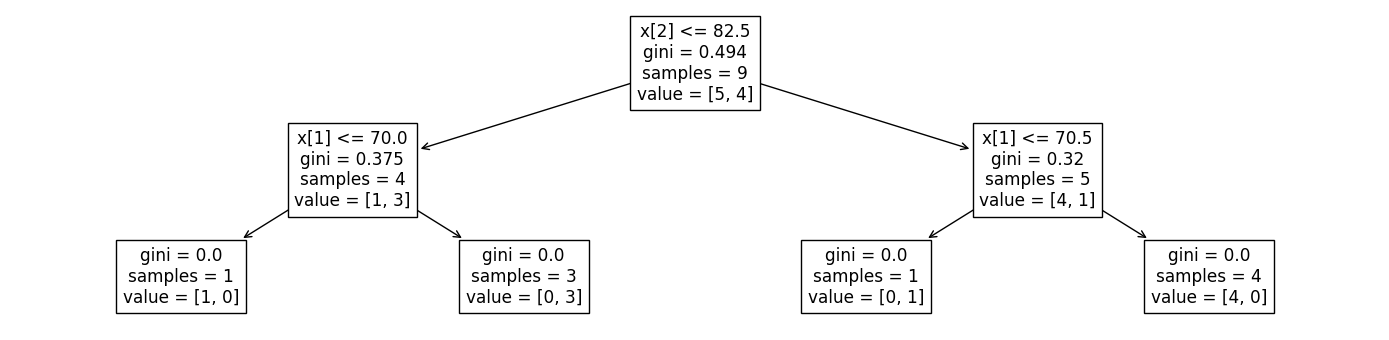

In [10]:
from sklearn.tree import plot_tree
plt.figure(figsize=figsize)
plot_tree(mdl);
plt.tight_layout(); plt.show()

## Evaluting the Tree

**Our DT can be evaluated as any other classification model**

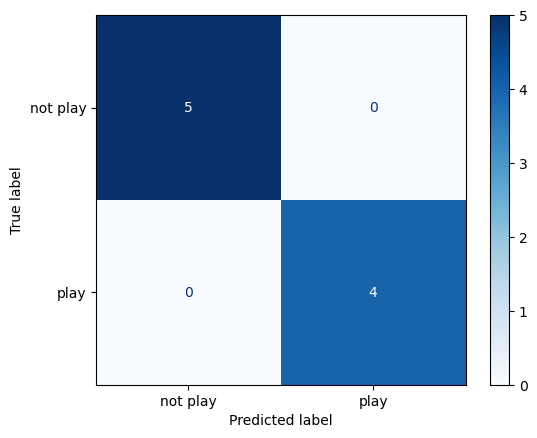

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
ConfusionMatrixDisplay.from_estimator(mdl, X_tr, y_tr, display_labels=['not play', 'play'], cmap='Blues');